In [4]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [5]:
import sys,os
sys.path.append('..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam, OptParamArray
from backtester.swarms.ranking import SwarmRanker
from backtester.swarms.rebalancing import SwarmRebalance
from backtester.swarms.filters import SwarmFilter
from backtester.costs import CostsManagerEXOFixed
from backtester.exoinfo import EXOInfo
from backtester.swarms.rankingclasses import *
from backtester.swarms.swarm import Swarm


import pandas as pd
import numpy as np
import scipy

In [6]:
from strategies.strategy_bbands import StrategyBollingerBands

In [7]:
from scripts.settings import *
try:
    from scripts.settings_local import *
except:
    pass

from exobuilder.data.exostorage import EXOStorage

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)


exo_filter = '*'     # All 
#exo_filter = 'ES_'  # ES only
exo_filter = 'ES*Collar'  # ES Collars (incl Bearish, Bullish, BW and vanilla)

[print(exo) for exo in storage.exo_list(exo_filter)];

ES_BullishCollarBW
ES_BearishCollarBW
ES_BullishCollar


## Script settings

In [8]:
STRATEGY_CONTEXT = {
    'strategy': { 
        'class': StrategyBollingerBands,
        'exo_name': 'ES_BearishCollarBW',        # <---- Select and paste EXO name from cell above
        'exo_storage': storage,
        'opt_params': [
                        #OptParam(name, default_value, min_value, max_value, step)
                        OptParamArray('Direction', [1]),
                        OptParam('BB_Period', 20, 10, 30, 10),
                        OptParam('BB_K', 2, 2, 5, 1),
            
                        ### Trend 0:5
                        #OptParamArray('RulesIndex', np.arange(26)[0:5]),
            
                        ### Vola breakout 5:10
                        #OptParamArray('RulesIndex', np.arange(26)[5:10]),
            
                        ### High vola(BBands width percent rank > 80-90) 10:15
                        #OptParamArray('RulesIndex', np.arange(26)[10:15]),
            
                        ### %B rules 15:26
                        OptParamArray('RulesIndex', np.arange(26)[15:26]),
            
                        ### All rules
                        #OptParamArray('RulesIndex', np.arange(26)[:]),
            
                        OptParam('MedianPeriod', 5, 1, 20, 1)
            ],
    },
    'swarm': {
        'members_count': 2,
        'ranking_class': RankerHighestReturns(return_period=14),
        'rebalance_time_function': SwarmRebalance.every_friday,

    },
    'costs':{
        'manager': CostsManagerEXOFixed,
        'context': {
            'costs_options': 3.0,
            'costs_futures': 3.0,
        }
    }
}

# Backtest class based strategy

### WARNING! Do not run next block if you want to load swarm from file!

In [9]:
smgr = Swarm(STRATEGY_CONTEXT)
smgr.run_swarm()
smgr.pick()

# Saving results to swarms directory
smgr.save('./swarms/')

### WARNING! Loading swarm from file (don't run next cell if you want new swarm instance)

In [6]:
#smgr = Swarm.load(strategy_context=STRATEGY_CONTEXT, directory='./swarms/')
#print('Loading: '+smgr.get_swarm_name())

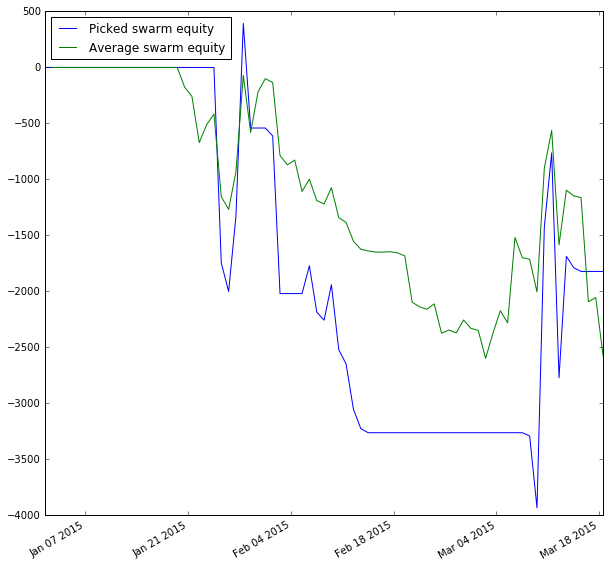

In [10]:
figsize(10,10)
smgr.picked_equity.plot(label='Picked swarm equity');
smgr.raw_equity.plot(label='Average swarm equity');
legend(loc=2);

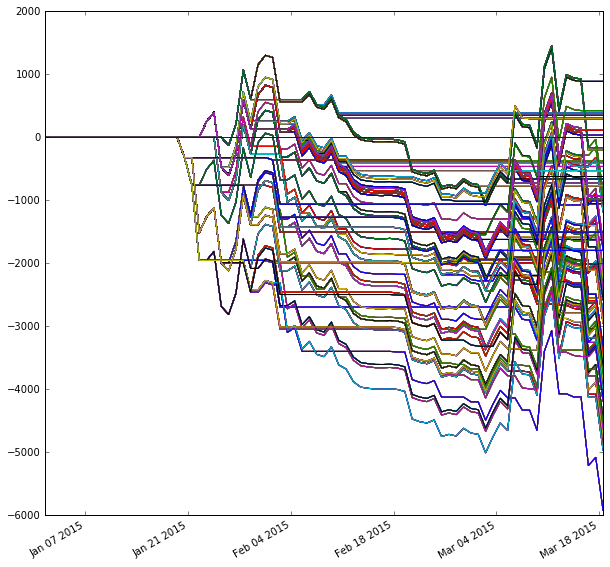

In [11]:
smgr.raw_swarm.plot(legend=False)

In [12]:
#
# To export swarms above to .csv, uncomment this
#

#swarm_df = smgr.swarm
#swarm_df.to_csv('./temp_swarms/ichi_swarm.csv')

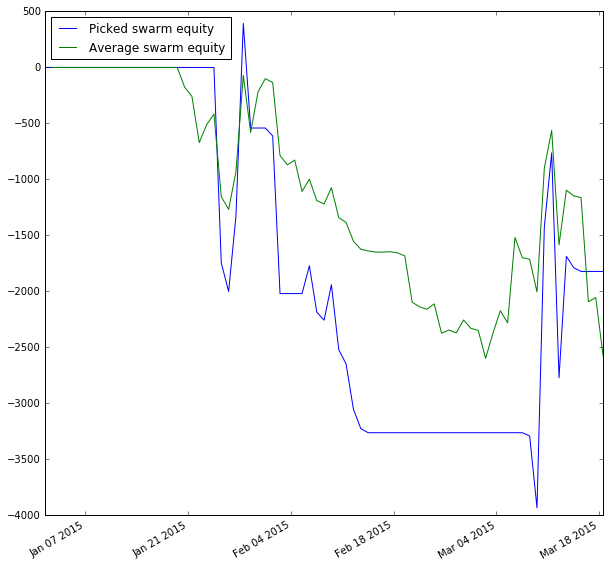

In [13]:
figsize(10,10)
smgr.picked_equity.plot(label='Picked swarm equity');
smgr.raw_equity.plot(label='Average swarm equity');
legend(loc=2);

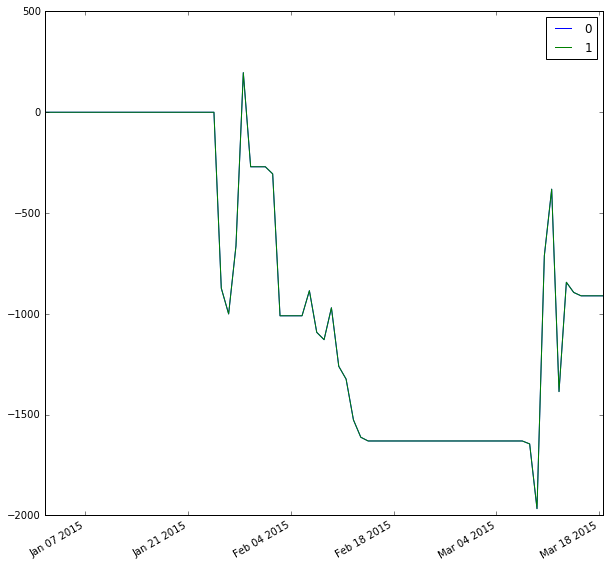

In [14]:
smgr.picked_swarm.plot()

# Swarm exposure

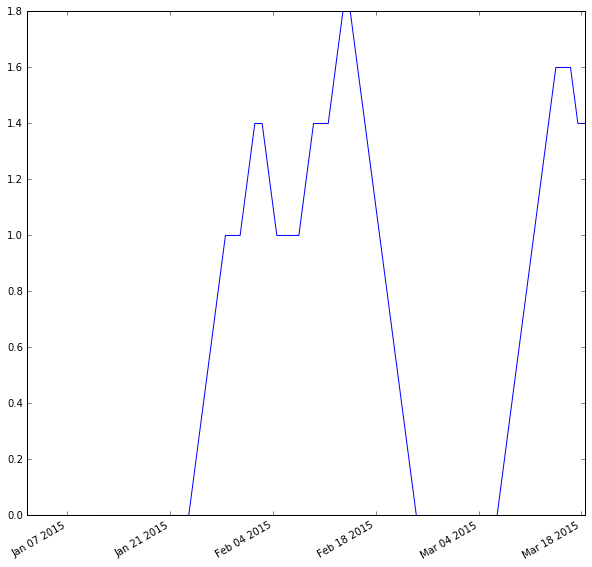

In [15]:
smgr.picked_exposure.sum(axis=1).rolling(10).mean().plot()

# Swarm statistics

#### Non-picked swarm stats

In [16]:
smgr.picked_stats

{'note:Not implemented yet'}

## Exo information

In [17]:
smgr.strategy.exoinfo.exo_info

{'margin': 0,
 'name': 'ES_BearishCollarBW',
 'pcf': [],
 'pcfqty': [],
 'underlying': ''}

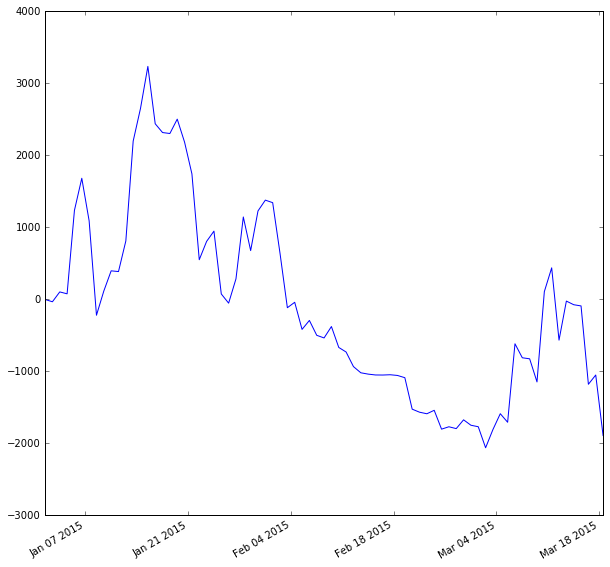

In [18]:
smgr.strategy.exoinfo.data.exo.plot()

### Global filter information (obsolete)


## Costs information (per 1-exo unit)

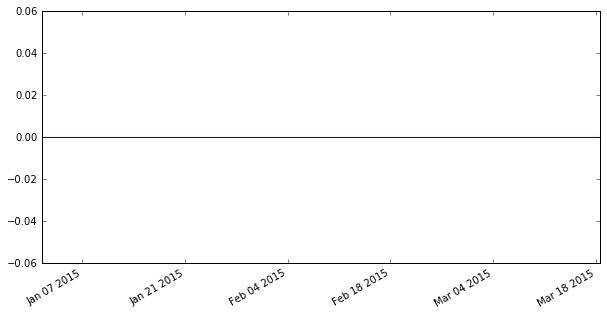

In [19]:
figsize(10,5)
smgr.strategy.costs.plot()

## Margin graphs

### EXO Margin (per 1 EXO unit)

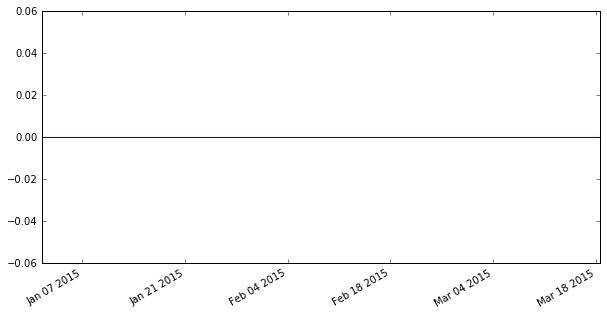

In [20]:
smgr.strategy.exoinfo.margin().plot()

# Saving results

In [21]:
smgr.save('./swarms/')